# Build Master Parcel Attribute Table (MPAT)
*Author: Alemarie Ceria*

## Purpose

This notebook constructs the Master Parcel Attribute Table (MPAT) for the Hawaiʻi OSDS Technology Suitability Analysis.

The MPAT is a parcel-level table where each row represents a parcel containing one or more Class IV cesspools, uniquely identified by TMK. It aggregates physical, environmental, and regulatory attributes required to evaluate onsite wastewater technology suitability.

## Version

Pilot: Oahu and Maui

## Setup

### Imports

In [1]:
import os
# Data handling
import pandas as pd
import numpy as np
# ArcPy
import arcpy
arcpy.env.overwriteOutput = True
# GDAL/OGR for raster extraction
from osgeo import gdal, ogr

# Display options
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 20)

### Configuration

In [2]:
# MPAT version
VERSION = "01"

# Pilot islands (set to None for all MHI)
PILOT_ISLANDS = ["OAH", "MAU"]

### Paths

In [3]:
# Project root
homedir = os.getcwd()

# Tempspace for intermediate Arc outputs
tempspace = os.path.abspath(os.path.join(homedir, "..", "data", "02_interim", "tempspace"))
if not os.path.exists(tempspace):
    os.makedirs(tempspace)

# Scratch geopackage for 64-bit integer support
scratch_gpkg = os.path.join(tempspace, "scratch.gpkg")

# Input paths
INPUT_DIR = os.path.abspath(os.path.join(homedir, "..", "data", "01_inputs", "prepared"))
inputs = {
    "parcels":     os.path.join(INPUT_DIR, "parcels_hi_higp_preprocessed_32604.gpkg"),
    "cesspools":   os.path.join(INPUT_DIR, "cesspools_inventory_hi_hcpt_corrected_32604.gpkg"),
    "coastline":   os.path.join(INPUT_DIR, "coastline_hi_op_32604.gpkg"),
    "sma":         os.path.join(INPUT_DIR, "sma_hi_op_32604.gpkg"),
    "streams":     os.path.join(INPUT_DIR, "streams_hi_hcpt_32604.gpkg"),
    "mun_wells":   os.path.join(INPUT_DIR, "wells_hi_hcpt_mun_32604.gpkg"),
    "dom_wells":   os.path.join(INPUT_DIR, "wells_hi_hcpt_dom_32604.gpkg"),
    "rainfall":    os.path.join(INPUT_DIR, "annual_rainfall_hi_hcpt_32604.tif"),
    "watertable":  os.path.join(INPUT_DIR, "watertable_hi_hcpt_mosaic_32604.tif"),
    "dem":         os.path.join(INPUT_DIR, "dem_hi_pacioos_mosaic_32604.tif"),
}

# Output paths
INTERIM_DIR = os.path.abspath(os.path.join(homedir, "..", "data", "02_interim"))
OUTPUT_DIR = os.path.abspath(os.path.join(homedir, "..", "data", "03_processed"))
outputs = {
    "mpat_gpkg": os.path.join(OUTPUT_DIR, f"mpat_v{VERSION}_32604.gpkg"),
    "mpat_csv":  os.path.join(OUTPUT_DIR, f"mpat_v{VERSION}.csv"),
}

# Verify inputs exist
print("Checking inputs...")
for name, path in inputs.items():
    exists = "✓" if os.path.exists(path) else "✗ MISSING"
    print(f"  {name}: {exists}")

print(f"\nTempspace: {tempspace}")
print(f"Outputs: {OUTPUT_DIR}")

Checking inputs...
  parcels: ✓
  cesspools: ✓
  coastline: ✓
  sma: ✓
  streams: ✓
  mun_wells: ✓
  dom_wells: ✓
  rainfall: ✓
  watertable: ✓
  dem: ✓

Tempspace: f:\projects\shuler_lab_projects\HiOSDS-TechSuitabilityAnalysis\data\02_interim\tempspace
Outputs: f:\projects\shuler_lab_projects\HiOSDS-TechSuitabilityAnalysis\data\03_processed


### Helper Functions

#### Utility

In [25]:
def describe_df(df, name="DataFrame"):
    """Print summary of a DataFrame."""
    print(f"\n{name}")
    print(f"    Rows: {len(df):,}")
    print(f"    Columns: {list(df.columns)}")


def describe_fc(fc_path, name="Feature Class"):
    """Print summary of a feature class."""
    print(f"\n{name}: {fc_path}")
    count = int(arcpy.management.GetCount(fc_path)[0])
    fields = [f.name for f in arcpy.ListFields(fc_path)]
    print(f"    Features: {count:,}")
    print(f"    Fields: {fields}")


def export_arc(tempspace, name, ext="shp"):
    """
    Create a subdirectory for an ArcPy output and return the file path.
    Keeps tempspace organized: tempspace/name/name.ext
    """
    subdir = os.path.join(tempspace, name)
    if not os.path.exists(subdir):
        os.makedirs(subdir)
    return os.path.join(subdir, f"{name}.{ext}")


def merge_to_mpat(mpat, new_df, on='tmk', how='left'):
    """
    Merge new columns to MPAT, replacing existing columns if they exist.
    """
    # Ensure join key is string in both DataFrames
    mpat[on] = mpat[on].astype(str)
    new_df[on] = new_df[on].astype(str)
    
    # Drop columns from mpat that are in new_df (except the join key)
    cols_to_drop = [c for c in new_df.columns if c in mpat.columns and c != on]
    if cols_to_drop:
        mpat = mpat.drop(columns=cols_to_drop)
    
    return mpat.merge(new_df, on=on, how=how)

def export_mpat(mpat_df, mpat_fc, outputs, tmk_field="tmk"):
    """
    Export MPAT to CSV and GeoPackage.
    
    Parameters:
        mpat_df: MPAT DataFrame
        mpat_fc: MPAT feature class (for geometry)
        outputs: dict with 'mpat_csv' and 'mpat_gpkg' paths
    """
    # Export CSV
    mpat_df.to_csv(outputs["mpat_csv"], index=False)
    print(f"Exported CSV: {outputs['mpat_csv']}")
    
    # Join DataFrame to feature class and export to GeoPackage
    # First, export df to temp table
    temp_csv = os.path.join(os.path.dirname(outputs["mpat_csv"]), "temp_mpat.csv")
    mpat_df.to_csv(temp_csv, index=False)
    
    # Make a copy of the feature class
    arcpy.MakeFeatureLayer_management(mpat_fc, "mpat_export_lyr")
    
    # Join the CSV to the feature layer
    arcpy.management.AddJoin(
        "mpat_export_lyr",
        "tmk_parcel",
        temp_csv,
        tmk_field,
        "KEEP_ALL"
    )
    
    # Export to GeoPackage
    arcpy.conversion.FeatureClassToFeatureClass(
        "mpat_export_lyr",
        os.path.dirname(outputs["mpat_gpkg"]),
        os.path.basename(outputs["mpat_gpkg"]).replace(".gpkg", ""),
        ""
    )
    
    # Clean up
    arcpy.management.RemoveJoin("mpat_export_lyr")
    os.remove(temp_csv)
    
    print(f"Exported GeoPackage: {outputs['mpat_gpkg']}")

def gpkg_fc(gpkg_path, preferred=None):
    """
    Return a full path to a feature class inside a gpkg.
    If preferred is given, tries to match it (exact or suffix match).
    """
    arcpy.env.workspace = gpkg_path
    fcs = arcpy.ListFeatureClasses() or []
    arcpy.env.workspace = None

    if not fcs:
        raise FileNotFoundError(f"No feature classes found in: {gpkg_path}")

    if preferred is None:
        return os.path.join(gpkg_path, fcs[0])

    # exact match first
    if preferred in fcs:
        return os.path.join(gpkg_path, preferred)

    # common ArcGIS naming: may prefix with "main."
    matches = [fc for fc in fcs if fc.endswith(preferred)]
    if len(matches) == 1:
        return os.path.join(gpkg_path, matches[0])

    raise FileNotFoundError(
        f"Could not find feature class '{preferred}' in {gpkg_path}. "
        f"Available: {fcs}"
    )

#### MPAT Calculations

In [5]:
def calc_cesspool_aggregates(cesspools_df, tmk_col='tmk_validated'):
    """
    Aggregate cesspool data per parcel.
    
    Parameters:
        cesspools_df: filtered cesspools DataFrame
        tmk_col: name of TMK column
    
    Returns:
        DataFrame with tmk and cesspool count
    """
    # Clean nodata values
    cesspools_clean = cesspools_df.copy()
    cesspools_clean.loc[cesspools_clean['bedroom'] < 0, 'bedroom'] = np.nan
    
    # Aggregate
    cesspool_agg = (
        cesspools_clean
        .groupby(tmk_col)
        .agg(
            n_cesspools=(tmk_col, 'size'),
            bedroom_sum=('bedroom', lambda x: x.sum(min_count=1)),
            effluent_sum=('effluent', lambda x: x.sum(min_count=1)),
            nitrogen_sum=('nitrogen', lambda x: x.sum(min_count=1)),
            phosphorus_sum=('phosphorus', lambda x: x.sum(min_count=1)),
        )
        .reset_index()
        .rename(columns={tmk_col: 'tmk'})
    )
    
    return cesspool_agg

def calc_parcel_area(parcels_fc, tmk_field="tmk_parcel"):
    """
    Calculate parcel area in square meters.
    
    Returns: DataFrame with tmk and area_sqm
    """
    arcpy.management.CalculateGeometryAttributes(
        parcels_fc, 
        [["area_sqm", "AREA"]], 
        area_unit="SQUARE_METERS"
    )
    
    areas = []
    with arcpy.da.SearchCursor(parcels_fc, [tmk_field, "area_sqm"]) as cursor:
        for row in cursor:
            areas.append({'tmk': str(row[0]), 'area_sqm': row[1]})
    
    return pd.DataFrame(areas)


def extract_raster_to_points(raster_path, points_fc, value_col, tmk_field="tmk_parcel"):
    """
    Extract raster values at point locations using GDAL.
    
    Returns: DataFrame with tmk and extracted values
    """
    raster_ds = gdal.Open(raster_path)
    band = raster_ds.GetRasterBand(1)
    gt = raster_ds.GetGeoTransform()
    nodata = band.GetNoDataValue()
    
    points_ds = ogr.Open(points_fc)
    layer = points_ds.GetLayer()
    
    results = []
    for feature in layer:
        geom = feature.GetGeometryRef()
        mx, my = geom.GetX(), geom.GetY()
        
        px = int((mx - gt[0]) / gt[1])
        py = int((my - gt[3]) / gt[5])
        
        if 0 <= px < raster_ds.RasterXSize and 0 <= py < raster_ds.RasterYSize:
            value = band.ReadAsArray(px, py, 1, 1)[0, 0]
            tmk = feature.GetField(tmk_field)
            
            is_valid = True
            if nodata is not None and value == nodata:
                is_valid = False
            elif value < -100:
                is_valid = False
            
            if is_valid:
                results.append({'tmk': str(tmk), value_col: float(value)})
    
    raster_ds = None
    points_ds = None
    
    return pd.DataFrame(results) if results else pd.DataFrame(columns=['tmk', value_col])


def calc_dist_to_feature(points_fc, target_fc, dist_col, scratch_gpkg, tmk_field="tmk_parcel"):
    """
    Calculate distance from points to nearest feature (1:1 per point).
    - Uses GenerateNearTable with closest=TRUE to enforce one record per input.
    - Also dedupes defensively by min(NEAR_DIST) per IN_FID.
    Returns: DataFrame with ['tmk', dist_col]
    """
    # Create scratch gpkg if needed
    if not arcpy.Exists(scratch_gpkg):
        arcpy.management.CreateSQLiteDatabase(scratch_gpkg, "GEOPACKAGE")

    # Convert polygons to lines if needed (coastline case)
    desc = arcpy.Describe(target_fc)
    if desc.shapeType == "Polygon":
        target_line_fc = os.path.join(scratch_gpkg, f"{dist_col}_line")
        if arcpy.Exists(target_line_fc):
            arcpy.management.Delete(target_line_fc)
        arcpy.management.PolygonToLine(target_fc, target_line_fc)
        target_fc = target_line_fc

    # Near table output
    near_table = os.path.join(scratch_gpkg, f"near_{dist_col}")
    if arcpy.Exists(near_table):
        arcpy.management.Delete(near_table)

    # closest="CLOSEST" enforces one near per input feature
    arcpy.analysis.GenerateNearTable(
        in_features=points_fc,
        near_features=target_fc,
        out_table=near_table,
        closest="CLOSEST",
        method="GEODESIC"
        # optional: add a search_radius if you want to cap distances
        # search_radius="5000 Meters"
    )

    # Read near table (IN_FID -> NEAR_DIST)
    near_rows = []
    with arcpy.da.SearchCursor(near_table, ["IN_FID", "NEAR_DIST"]) as cursor:
        for in_fid, near_dist in cursor:
            near_rows.append({"IN_FID": int(in_fid), dist_col: float(near_dist)})

    near_df = pd.DataFrame(near_rows)

    # Match 1:1
    if not near_df.empty:
        near_df = (
            near_df
            .groupby("IN_FID", as_index=False)[dist_col]
            .min()
        )

    # Build IN_FID -> TMK mapping from the points feature class OID
    fid_rows = []
    with arcpy.da.SearchCursor(points_fc, ["OID@", tmk_field]) as cursor:
        for oid, tmk in cursor:
            fid_rows.append({"IN_FID": int(oid), "tmk": str(tmk)})

    fid_df = pd.DataFrame(fid_rows)

    # Left join so every centroid stays present even if near failed
    out = fid_df.merge(near_df, on="IN_FID", how="left")[["tmk", dist_col]]

    return out

def flag_parcels_intersecting_polygons(parcels_fc, polygons_fc, flag_col, tmk_field="tmk_parcel"):
    """
    Flag parcels that intersect polygons.
    
    Returns: DataFrame with tmk and boolean flag column
    """
    arcpy.MakeFeatureLayer_management(polygons_fc, "poly_lyr")
    arcpy.MakeFeatureLayer_management(parcels_fc, "parcels_lyr")
    
    arcpy.SelectLayerByLocation_management("parcels_lyr", "INTERSECT", "poly_lyr")
    
    count = int(arcpy.GetCount_management("parcels_lyr")[0])
    print(f"  Parcels intersecting {flag_col}: {count:,}")
    
    tmks = []
    with arcpy.da.SearchCursor("parcels_lyr", [tmk_field]) as cursor:
        for row in cursor:
            tmks.append(str(row[0]))
    
    arcpy.SelectLayerByAttribute_management("parcels_lyr", "CLEAR_SELECTION")
    
    return pd.DataFrame({"tmk": tmks, flag_col: 1})

#### Visualizations

In [6]:
def hist_and_stats_on_df(df, col): 
    # THis plots a histogram and gives basic stats for a numeric dataframe column
    
    df[col].hist(bins=50)
    print("Average {} is {}".format(col, df[col].mean()))
    print("Max {} is {}".format(col, df[col].max()))
    print("Min {} is {}".format(col, df[col].min()))

## Load Base Layers

### Cesspools

In [7]:
print("Loading cesspools...")

cesspools_fc = os.path.join(inputs["cesspools"], "main.cesspools_inventory_hi_hcpt_corrected_32604")

# Convert to CSV
cesspools_csv = export_arc(tempspace, "cesspools_df", "csv")
arcpy.TableToTable_conversion(cesspools_fc, os.path.dirname(cesspools_csv), "cesspools_df.csv")
cesspools_df = pd.read_csv(cesspools_csv)

describe_df(cesspools_df, name="Cesspools")
print("\nTMK status values:")
print(cesspools_df['tmk_status'].value_counts())

Loading cesspools...

Cesspools
    Rows: 85,512
    Columns: ['OID_', 'tmk_cps', 'class_i', 'class_ii', 'class_iii', 'class_iv', 'class_v', 'osds_qty', 'bedroom', 'effluent', 'nitrogen', 'phosphorus', 'tmk_validated', 'tmk_status']

TMK status values:
tmk_status
match_ok                         78702
hit_but_tmk_exists_elsewhere      6086
tmk_corrected                      667
geometry_corrected                  40
nearest_corrected                   14
review_nohit_beyond_threshold        3
Name: count, dtype: int64


In [8]:
# Filter to valid TMK statuses
valid_statuses = [
    'match_ok',
    'tmk_corrected',
    'geometry_corrected', 
    'nearest_corrected'
]

cesspools_filtered = cesspools_df[cesspools_df['tmk_status'].isin(valid_statuses)].copy()

print(f"Cesspools after filter: {len(cesspools_filtered):,} (dropped {len(cesspools_df) - len(cesspools_filtered):,})")

Cesspools after filter: 79,423 (dropped 6,089)


### Parcels

In [9]:
print("Loading parcels...")

parcels_fc = os.path.join(inputs["parcels"], "main.parcels_hi_higp_preprocessed_32604")

# Convert to CSV
parcels_csv = export_arc(tempspace, "parcels", "csv")
arcpy.TableToTable_conversion(parcels_fc, os.path.dirname(parcels_csv), "parcels.csv")
parcels_df = pd.read_csv(parcels_csv)

describe_df(parcels_df, name="Parcels")

Loading parcels...

Parcels
    Rows: 384,260
    Columns: ['OID_', 'tmk_parcels', 'island']


In [10]:
# Filter to parcels with cesspools
cesspool_tmks = cesspools_filtered['tmk_validated'].unique()
parcels_filtered = parcels_df[parcels_df['tmk_parcels'].isin(cesspool_tmks)].copy()

print(f"Unique TMKs with cesspools: {len(cesspool_tmks):,}")
print(f"Parcels with cesspools: {len(parcels_filtered):,} (of {len(parcels_df):,} total)")

Unique TMKs with cesspools: 69,575
Parcels with cesspools: 69,575 (of 384,260 total)


## Build MPAT

Workflow overview:
1. Cesspool count per parcel (tabular)
2. Parcel area (geometry)
3. Raster extractions (elevation, water table, rainfall)
4. Depth to water table (derived)
5. Distance to coast
6. SMA intersection (flag)

### Initialize Base DataFrame

In [11]:
# Filter to pilot islands
print("Island counts:")
print(parcels_filtered["island"].value_counts(dropna=False))

if PILOT_ISLANDS:
    mpat = (
        parcels_filtered[
            parcels_filtered["island"].astype("string").str.upper().isin(PILOT_ISLANDS)
        ]
        .copy()
        .rename(columns={"tmk_parcels": "tmk"})
    )
    print(f"\nFiltered to {PILOT_ISLANDS}: {len(mpat):,} parcels")
else:
    mpat = parcels_filtered.copy().rename(columns={"tmk_parcels": "tmk"})
    print(f"\nAll islands: {len(mpat):,} parcels")

Island counts:
island
HAW    41750
OAH     9954
KAU     9868
MAU     6982
MOL     1021
Name: count, dtype: int64

Filtered to ['OAH', 'MAU']: 16,936 parcels


### Create Spatial Layers

In [43]:
# Build where clause from TMK list
tmk_list = mpat['tmk'].astype(str).tolist()
tmk_str = "','".join(tmk_list)
where_clause = f"tmk_parcels IN ('{tmk_str}')"

# Export filtered parcels
arcpy.MakeFeatureLayer_management(parcels_fc, "parcels_lyr", where_clause)
mpat_fc = os.path.join(scratch_gpkg, "mpat_parcels")
arcpy.conversion.ExportFeatures("parcels_lyr", mpat_fc)

# Create centroids for point-based operations
centroids_fc = os.path.join(scratch_gpkg, "mpat_centroids")
arcpy.management.FeatureToPoint(mpat_fc, centroids_fc, "CENTROID")

print(f"Parcels feature class: {int(arcpy.GetCount_management(mpat_fc)[0]):,}")
print(f"Centroids feature class: {int(arcpy.GetCount_management(centroids_fc)[0]):,}")

# Verify TMK preserved 
tmk_field = "tmk_parcels"
with arcpy.da.SearchCursor(mpat_fc, [tmk_field]) as cursor:
    sample = [row[0] for row in cursor][:5]
print(f"Sample TMKs: {sample}")

Parcels feature class: 16,936
Centroids feature class: 16,936
Sample TMKs: ['211003003', '211003006', '211003012', '211003030', '211003031']


### Cesspool aggregates

In [13]:
print("Calculating aggregations...")

cesspool_df = calc_cesspool_aggregates(cesspools_filtered)
mpat = merge_to_mpat(mpat, cesspool_df)

print(f"\nAggregation stats:")
print(mpat.describe())

Calculating aggregations...

Aggregation stats:
                OID_   n_cesspools   bedroom_sum  effluent_sum  nitrogen_sum  \
count   16936.000000  16936.000000  16936.000000  16936.000000  16936.000000   
mean   235234.089927      1.149681      3.897556    534.653342      0.171547   
std     77712.380993      0.508421      4.574297   1014.002700      0.332650   
min    135528.000000      1.000000      0.000000      0.000000      0.000000   
25%    147979.500000      1.000000      2.000000    315.000000      0.103739   
50%    251449.000000      1.000000      3.000000    420.000000      0.103739   
75%    303654.250000      1.000000      4.000000    600.000000      0.197603   
max    384260.000000     33.000000    144.000000  36800.000000     12.119374   

       phosphorus_sum  
count    16936.000000  
mean         0.037108  
std          0.073032  
min          0.000000  
25%          0.022656  
50%          0.022656  
75%          0.043155  
max          2.646760  


### Parcel Area

In [14]:
print("Calculating parcel areas...")

area_df = calc_parcel_area(mpat_fc)
mpat = merge_to_mpat(mpat, area_df)

print(f"\nParcel area stats (sq m):")
print(mpat['area_sqm'].describe())

Calculating parcel areas...

Parcel area stats (sq m):
count    1.693600e+04
mean     3.139899e+04
std      7.123736e+05
min      1.480406e+02
25%      7.091096e+02
50%      1.666255e+03
75%      5.039319e+03
max      6.661736e+07
Name: area_sqm, dtype: float64


### Raster Extractions

#### Average rainfall

Extracting rainfall...


C:\Users\apc\AppData\Local\ESRI\conda\envs\matrix_env\Lib\site-packages\osgeo\gdal.py:606: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


  Extracted: 16,931 points
Average rainfall_mm is 44.567187746814135
Max rainfall_mm is 207.231201171875
Min rainfall_mm is 10.63902473449707


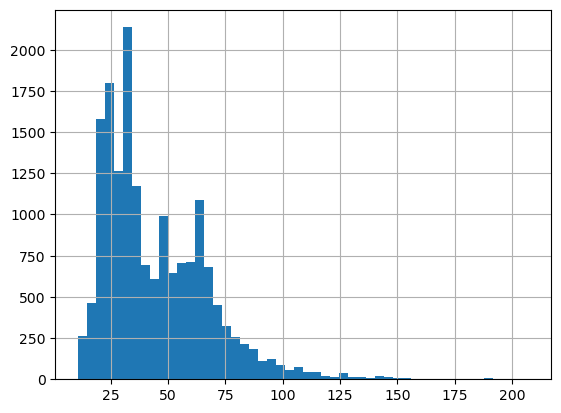

In [15]:
print("Extracting rainfall...")
rainfall_df = extract_raster_to_points(inputs["rainfall"], centroids_fc, "rainfall_mm")
mpat = merge_to_mpat(mpat, rainfall_df)
print(f"  Extracted: {len(rainfall_df):,} points")
hist_and_stats_on_df(rainfall_df, "rainfall_mm")

#### Slope

In [16]:
# %%time
# blankframe = pd.DataFrame(columns=["Uid"])

# indir = os.path.join("..", "Large_Projected_data\\DEMs\\Slope_WGS")  # Using a loop to go over different rasters from different islands
# for idx, file in enumerate(os.listdir(indir)):
#     if file.endswith(".tif"):
#         In_raster = os.path.join(indir, file)
#         In_points = osds_path
#         new_col_name = "slope_{}".format(idx)       
#         foo = extract_values_from_rasters(In_raster, In_points, new_col_name, tempspace)
#         blankframe = blankframe.merge(foo, how='outer', on='Uid')

# blankframe.set_index("Uid", inplace=True)
# blankframe['slope_deg'] = blankframe.max(axis=1)  
# blankframe.reset_index(inplace=True)

# SLOPE = blankframe[["Uid", 'slope_deg']]
# SLOPE.to_csv(os.path.join(intermidiate_DataFramesPath, "SLOPE.csv"))
# # plot histogram
# Hist_and_stats_on_DF(SLOPE, "slope_deg")

#### Land surface elevations

Extracting elevation...
  Extracted: 16,936 points
Average elevation_m is 194.83788668043331
Max elevation_m is 3025.53369140625
Min elevation_m is 0.05160054564476013


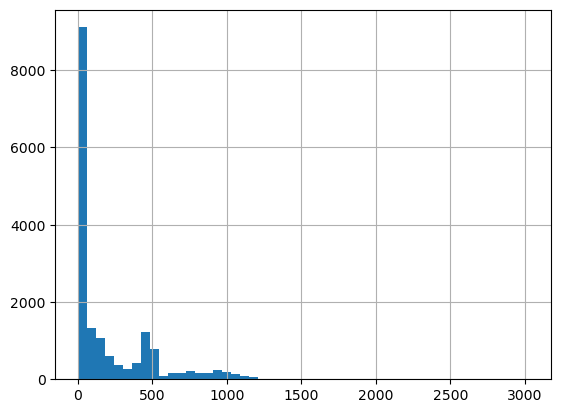

In [17]:
print("Extracting elevation...")
elevation_df = extract_raster_to_points(inputs["dem"], centroids_fc, "elevation_m")
mpat = merge_to_mpat(mpat, elevation_df)
print(f"  Extracted: {len(elevation_df):,} points")
hist_and_stats_on_df(elevation_df, "elevation_m")

#### Water table depths

Extracting water table...
  Extracted: 16,243 points
Average watertable_m is 3.9522536760156526
Max watertable_m is 280.26226806640625
Min watertable_m is 0.3009399473667145


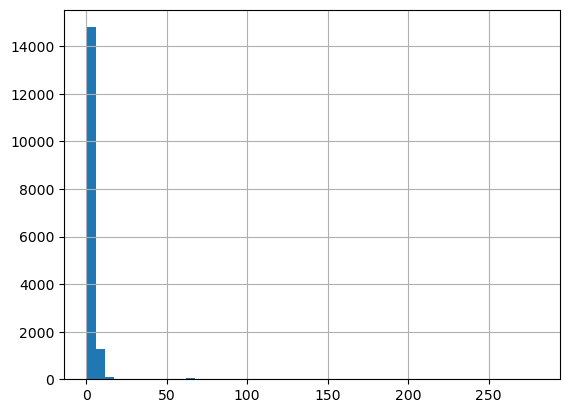

In [18]:
print("Extracting water table...")
watertable_df = extract_raster_to_points(inputs["watertable"], centroids_fc, "watertable_m")
mpat = merge_to_mpat(mpat, watertable_df)
print(f"  Extracted: {len(watertable_df):,} points")
hist_and_stats_on_df(watertable_df, "watertable_m")

In [19]:
print("Extraction summary:")
print(f"  Elevation missing: {mpat['elevation_m'].isna().sum():,}")
print(f"  Water table missing: {mpat['watertable_m'].isna().sum():,}")
print(f"  Rainfall missing: {mpat['rainfall_mm'].isna().sum():,}")

Extraction summary:
  Elevation missing: 99
  Water table missing: 693
  Rainfall missing: 5


### Depth to Water Table

Parcels with negative depth: 2,332

Depth to water stats (m):
count    16164.000000
mean       197.426527
std        283.132730
min          0.011736
25%          2.634320
50%         41.334458
75%        364.632493
max       3009.679640
Name: depth_to_water_m, dtype: float64
Average depth_to_water_m is 197.4265273436196
Max depth_to_water_m is 3009.679639816284
Min depth_to_water_m is 0.011736392974853516


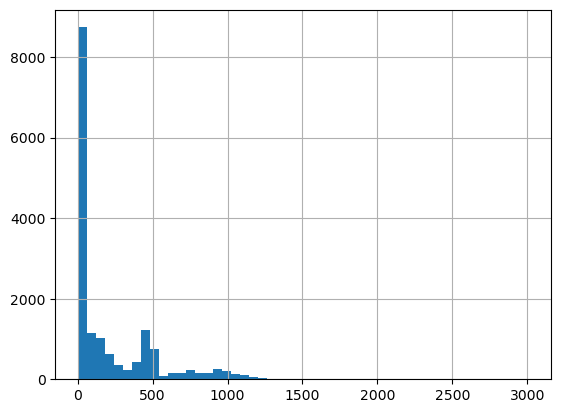

In [20]:
mpat['depth_to_water_m'] = mpat['elevation_m'] - mpat['watertable_m']

# Handle negative values (water table above surface)
negative_count = (mpat['depth_to_water_m'] < 0).sum()
print(f"Parcels with negative depth: {negative_count:,}")

mpat.loc[mpat['depth_to_water_m'] < 0, 'depth_to_water_m'] = 0.999

print(f"\nDepth to water stats (m):")
print(mpat['depth_to_water_m'].describe())
hist_and_stats_on_df(mpat, "depth_to_water_m")

### Distance calculations

#### Coastline

In [23]:
fcs, tbls = list_gpkg_layers(inputs["coastline"])


GPKG: f:\projects\shuler_lab_projects\HiOSDS-TechSuitabilityAnalysis\data\01_inputs\prepared\coastline_hi_op_32604.gpkg
Feature classes:
  - main.coastline
Tables:


Calculating distance to coast...

Distance to coast stats (m):
count    16936.000000
mean      3712.704161
std       4379.633136
min          0.138092
25%        365.357777
50%       1695.653171
75%       5514.352555
max      16692.286073
Name: dist_to_coast_m, dtype: float64
Average dist_to_coast_m is 3712.7041605858553
Max dist_to_coast_m is 16692.28607257758
Min dist_to_coast_m is 0.1380921528205666


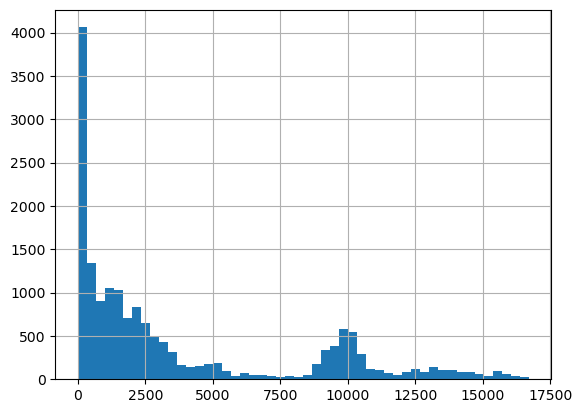

In [26]:
print("Calculating distance to coast...")

coastline_fc = gpkg_fc(inputs["coastline"], preferred="coastline")

dist_coast_df = calc_dist_to_feature(centroids_fc, coastline_fc, "dist_to_coast_m", scratch_gpkg)
mpat = merge_to_mpat(mpat, dist_coast_df)

print(f"\nDistance to coast stats (m):")
print(mpat['dist_to_coast_m'].describe())
hist_and_stats_on_df(mpat, "dist_to_coast_m")

#### Streams

Calculating distance to streams...

Distance to stream stats (m):
count    16936.000000
mean       524.271826
std        681.874594
min          0.256951
25%        139.438610
50%        291.896092
75%        552.997783
max       4956.143821
Name: dist_to_stream_m, dtype: float64
Average dist_to_stream_m is 524.2718261402227
Max dist_to_stream_m is 4956.143821491017
Min dist_to_stream_m is 0.25695088482987466


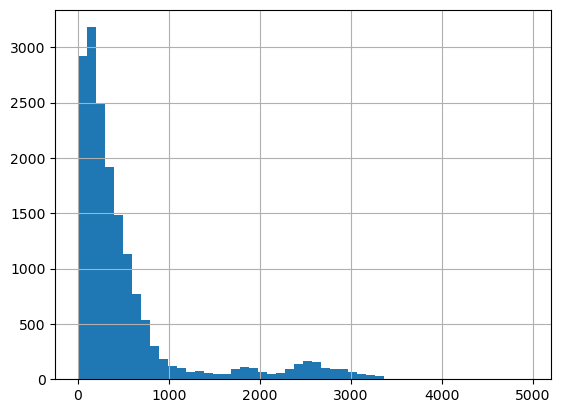

In [29]:
print("Calculating distance to streams...")

streams_fc = gpkg_fc(inputs["streams"], preferred="streams")

dist_stream_df = calc_dist_to_feature(centroids_fc, streams_fc, "dist_to_stream_m", scratch_gpkg)
mpat = merge_to_mpat(mpat, dist_stream_df)

print(f"\nDistance to stream stats (m):")
print(mpat['dist_to_stream_m'].describe())
hist_and_stats_on_df(mpat, "dist_to_stream_m")

#### Municipal Wells

Calculating distance to municipal wells...

Distance to municipal wells stats (m):
count    16936.000000
mean      2711.452209
std       2085.338376
min          4.794393
25%       1136.771984
50%       2070.912340
75%       3687.442718
max      20007.403975
Name: dist_to_mun_well_m, dtype: float64
Average dist_to_mun_well_m is 2711.4522086814904
Max dist_to_mun_well_m is 20007.403974584362
Min dist_to_mun_well_m is 4.794393454443971


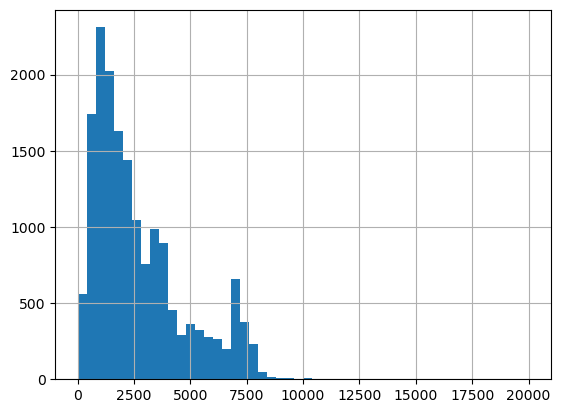

In [30]:
print("Calculating distance to municipal wells...")

mun_wells_fc = gpkg_fc(inputs["mun_wells"], preferred="mun_wells")

dist_mun_df = calc_dist_to_feature(
    centroids_fc,
    mun_wells_fc,
    "dist_to_mun_well_m",
    scratch_gpkg
)
mpat = merge_to_mpat(mpat, dist_mun_df)

print(f"\nDistance to municipal wells stats (m):")
print(mpat["dist_to_mun_well_m"].describe())
hist_and_stats_on_df(mpat, "dist_to_mun_well_m")

#### Domestic Wells

Calculating distance to domestic wells...

Distance to domestic wells stats (m):
count    16936.000000
mean      3245.903200
std       2149.877067
min          1.169563
25%       1565.967565
50%       2837.694852
75%       4637.340405
max      19444.317283
Name: dist_to_dom_well_m, dtype: float64
Average dist_to_dom_well_m is 3245.9031997123257
Max dist_to_dom_well_m is 19444.317283159275
Min dist_to_dom_well_m is 1.1695632978095367


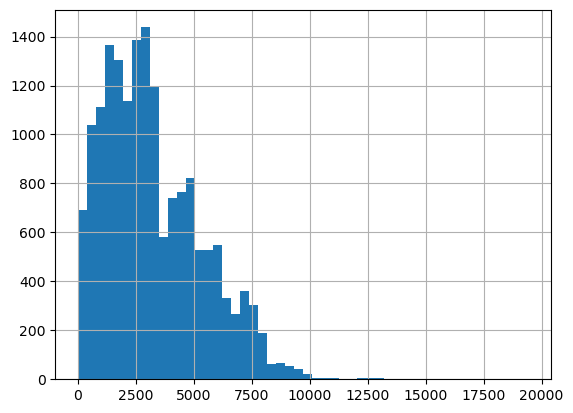

In [31]:
print("Calculating distance to domestic wells...")

dom_wells_fc = gpkg_fc(inputs["dom_wells"], preferred="dom_wells")

dist_dom_df = calc_dist_to_feature(
    centroids_fc,
    dom_wells_fc,
    "dist_to_dom_well_m",
    scratch_gpkg
)
mpat = merge_to_mpat(mpat, dist_dom_df)

print(f"\nDistance to domestic wells stats (m):")
print(mpat["dist_to_dom_well_m"].describe())
hist_and_stats_on_df(mpat, "dist_to_dom_well_m")

### SMA Intersection

In [33]:
print("Flagging SMA parcels...")

sma_fc = gpkg_fc(inputs["sma"], preferred="sma")

sma_df = flag_parcels_intersecting_polygons(mpat_fc, sma_fc, "in_sma")
mpat = merge_to_mpat(mpat, sma_df)
mpat["in_sma"] = mpat["in_sma"].fillna(0).astype("int8")

print(f"\nSMA stats:")
print(mpat['in_sma'].value_counts())

Flagging SMA parcels...
  Parcels intersecting in_sma: 4,416

SMA stats:
in_sma
0    12520
1     4416
Name: count, dtype: int64


## Final MPAT

### Summary

In [37]:
# How many have exactly 1.0 elevation?
print(mpat[mpat['elevation_m'] == 1.0].shape[0])
print(mpat[mpat['elevation_m'] == 1.0][['tmk', 'dist_to_coast_m', 'island']])

1625
             tmk  dist_to_coast_m island
428    221006011        24.938606    MAU
429    221006012        43.260291    MAU
6056   232010001       211.698629    MAU
6135   233001028        36.638855    MAU
6141   233001046        33.028003    MAU
...          ...              ...    ...
16886  153004025        47.518615    OAH
16887  153004024        50.073790    OAH
16897  153006002        40.811460    OAH
16933  121055001       467.894565    OAH
16934  126020002       545.624270    OAH

[1625 rows x 3 columns]


In [34]:
print(f"MPAT shape: {mpat.shape}")
print(f"\nColumns ({len(mpat.columns)}): {mpat.columns.tolist()}")

print("\nMissing values:")
print(mpat.isna().sum())

print("\nFlag distributions:")
print(mpat["in_sma"].value_counts(dropna=False))

print("\nIsland counts:")
print(mpat["island"].value_counts())

print("\nNumeric summary:")
mpat.describe()

MPAT shape: (16936, 18)

Columns (18): ['OID_', 'tmk', 'island', 'n_cesspools', 'bedroom_sum', 'effluent_sum', 'nitrogen_sum', 'phosphorus_sum', 'area_sqm', 'rainfall_mm', 'elevation_m', 'watertable_m', 'depth_to_water_m', 'dist_to_coast_m', 'dist_to_stream_m', 'dist_to_mun_well_m', 'dist_to_dom_well_m', 'in_sma']

Missing values:
OID_                  0
tmk                   0
island                0
n_cesspools           0
bedroom_sum           0
                     ..
dist_to_coast_m       0
dist_to_stream_m      0
dist_to_mun_well_m    0
dist_to_dom_well_m    0
in_sma                0
Length: 18, dtype: int64

Flag distributions:
in_sma
0    12520
1     4416
Name: count, dtype: int64

Island counts:
island
OAH    9954
MAU    6982
Name: count, dtype: int64

Numeric summary:


,OID_,n_cesspools,bedroom_sum,effluent_sum,nitrogen_sum,phosphorus_sum,area_sqm,rainfall_mm,elevation_m,watertable_m,depth_to_water_m,dist_to_coast_m,dist_to_stream_m,dist_to_mun_well_m,dist_to_dom_well_m,in_sma
count,16936.000000,16936.000000,16936.000000,16936.000000,16936.000000,16936.000000,1.693600e+04,16931.000000,16837.000000,16243.000000,16164.000000,16936.000000,16936.000000,16936.000000,16936.000000,16936.000000
mean,235234.089927,1.149681,3.897556,534.653342,0.171547,0.037108,3.139899e+04,44.567188,194.837887,3.952254,197.426527,3712.704161,524.271826,2711.452209,3245.903200,0.260746
std,77712.380993,0.508421,4.574297,1014.002700,0.332650,0.073032,7.123736e+05,22.932817,280.541638,5.389915,283.132730,4379.633136,681.874594,2085.338376,2149.877067,0.439055
min,135528.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.480406e+02,10.639025,0.051601,0.300940,0.011736,0.138092,0.256951,4.794393,1.169563,0.000000
25%,147979.500000,1.000000,2.000000,315.000000,0.103739,0.022656,7.091096e+02,26.547860,5.312949,2.487948,2.634320,365.357777,139.438610,1136.771984,1565.967565,0.000000
50%,251449.000000,1.000000,3.000000,420.000000,0.103739,0.022656,1.666255e+03,37.512756,40.392704,3.345726,41.334458,1695.653171,291.896092,2070.912340,2837.694852,0.000000
75%,303654.250000,1.000000,4.000000,600.000000,0.197603,0.043155,5.039319e+03,60.139339,342.629944,4.498987,364.632493,5514.352555,552.997783,3687.442718,4637.340405,1.000000
max,384260.000000,33.000000,144.000000,36800.000000,12.119374,2.646760,6.661736e+07,207.231201,3025.533691,280.262268,3009.679640,16692.286073,4956.143821,20007.403975,19444.317283,1.000000


### Export

CSV:

In [36]:
# Export to CSV
mpat = mpat.drop(columns=["OID_"], errors="ignore")
mpat.to_csv(outputs["mpat_csv"], index=False)
print(f"Exported to: {outputs['mpat_csv']}")

Exported to: f:\projects\shuler_lab_projects\HiOSDS-TechSuitabilityAnalysis\data\03_processed\mpat_v01.csv


Feature class:

In [46]:
import geopandas as gpd

# Read feature class
gdf = gpd.read_file(scratch_gpkg, layer="mpat_parcels")

# Ensure string types
gdf['tmk_parcels'] = gdf['tmk_parcels'].astype(str)
mpat['tmk'] = mpat['tmk'].astype(str)

# Merge
gdf_merged = gdf.merge(mpat, left_on='tmk_parcels', right_on='tmk', how='left')

# Clean up duplicate columns
cols_to_drop = [c for c in gdf_merged.columns if c.endswith('_y')]
gdf_merged = gdf_merged.drop(columns=cols_to_drop, errors='ignore')
gdf_merged.columns = [c.replace('_x', '') for c in gdf_merged.columns]

# Export
gdf_merged.to_file(outputs["mpat_gpkg"], driver="GPKG", layer="mpat")

print(f"Exported: {outputs['mpat_gpkg']}")
print(f"Shape: {gdf_merged.shape}")
print(f"Columns: {gdf_merged.columns.tolist()}")

Exported: f:\projects\shuler_lab_projects\HiOSDS-TechSuitabilityAnalysis\data\03_processed\mpat_v01_32604.gpkg
Shape: (16936, 19)
Columns: ['tmk_parcels', 'island', 'geometry', 'tmk', 'n_cesspools', 'bedroom_sum', 'effluent_sum', 'nitrogen_sum', 'phosphorus_sum', 'area_sqm', 'rainfall_mm', 'elevation_m', 'watertable_m', 'depth_to_water_m', 'dist_to_coast_m', 'dist_to_stream_m', 'dist_to_mun_well_m', 'dist_to_dom_well_m', 'in_sma']
